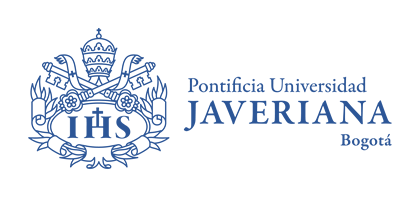

# Aprendizaje de máquina - Taller 2 - Redes neuronales artificiales
En este notebook vamos a explorar implementaciones de redes neuronales feedforward en usando la librería keras y se propone el enunciado del taller 2 del curso.

## Setup

Importaremos las librerías necesarias para el ejercicio

In [59]:
import pandas as pd
import numpy as np
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from pathlib import Path


## Redes neuronales artificiales feedforward

Las redes neuronales de alimentación hacia adelante son modelos de aprendizaje de máquina que conectan las unidades neuronales en capas. Estos modelos tienen una capa de entrada que recibe las instancias, una o más capas intermedias o capas ocultas, y una capa de salida o final que da la respuesta según el problema a resolver (regresión o clasificación). Las unidades neuronales de una capa reciben las activaciones de todas las unidades neuronales de la capa anterior y conectan su activación a todas las unidades neuronales de la capa siguiente.


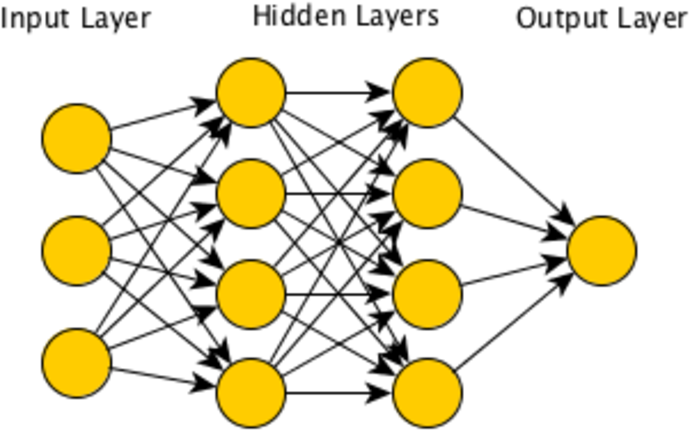

Las redes neuronales artificiales de alimentación hacia adelante son modeladores universales de funciones siempre y cuando se puedan añadir [suficientes unidades neuronales o suficientes capas](https://en.wikipedia.org/wiki/Universal_approximation_theorem)






## Ejercicio - Espirales

Ilustremos inicialmente el uso del modelo de clasificación de redes neuronales utilizando el ejemplo de las espirales que no eran separables por el perceptrón o ADALINE.




In [60]:
N=1000

In [61]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(N)
y

array([0., 0., 0., ..., 1., 1., 1.])

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [63]:
X_train.shape

(1600, 2)

In [64]:
X_test.shape

(400, 2)

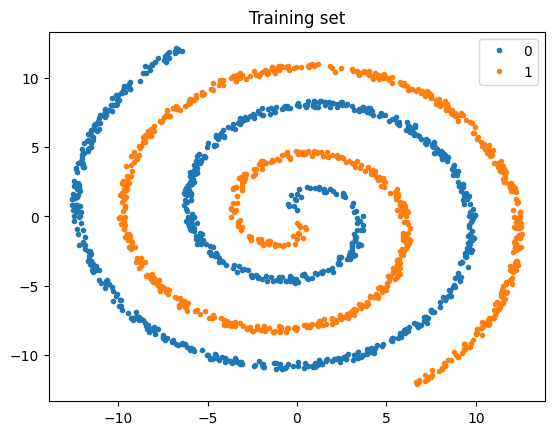

In [65]:
plt.title('Training set')
plt.plot(X_train[Y_train==0,0], X_train[Y_train==0,1], '.', label=0)
plt.plot(X_train[Y_train==1,0], X_train[Y_train==1,1], '.', label=1)
plt.legend()
plt.show()

### Partición datos en entrenamiento, validación y test

A continuación crearemos 3 datasets a partir del dataset no separable linealmente

In [66]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [67]:
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [68]:
len(X_train)

1600

In [69]:
X_train

array([[-1.21440444,  7.55009066],
       [-1.12117829, -4.61756529],
       [-5.36261866, -1.95613256],
       ...,
       [-8.49353387, 10.87772144],
       [-9.62195724,  0.64028051],
       [ 3.73919441, 10.41831249]])

In [70]:
len(X_val)

200

In [71]:
len(X_test)

200

# Callbacks
* EarlyStopping
    - Qué: detiene el entrenamiento si val_loss deja de mejorar durante patience=10 épocas.
    - Por qué: evita sobreentrenar y ahorra tiempo cuando el modelo ya no progresa.
* ModelCheckpoint
    - Qué: guarda el mejor modelo (según val_loss mínima) en la ruta indicada.
    - Por qué: garantiza que conservas el estado que mejor generaliza.
* Modelo
    - Arquitectura
        - Dos capas densas de 32 unidades con ReLU y una salida de 1 neurona con sigmoid: típico para clasificación binaria (predice probabilidad de clase positiva).
    - input_shape
        - Qué: especifica la dimensión de entrada.
        - Observación: lo pones dos veces y usas len(X[1]).
            - Solo la primera capa debe tener input_shape.
            - Es más robusto usar X.shape[1] (nº de columnas/feats) que len(X[1]) (segunda fila; asume que existe y se interpreta como nº de columnas, pero es frágil).
* Compilación
    - Optimizador
        - Qué: Adam con learning rate 0.01, que es alto para redes densas; puede inestabilizar.
        - Sugerencia: empezar con 1e-3 o 3e-4; si se estanca, usar ReduceLROnPlateau.
    - Pérdida
        - Qué: binary_crossentropy es la correcta para binario con salida sigmoide.
* Entrenamiento
    - Qué: entrena hasta 300 épocas, con validación, usando los callbacks para detener y guardar el mejor.
    - Por qué: flujo estándar; history te permite graficar curvas de loss/accuracy.



In [116]:
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callback_checkpoint = ModelCheckpoint(filepath='/tmp/checkpoints.keras',monitor='val_loss', mode='min',save_best_only=True)


model = keras.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(len(X[1]),)))
model.add(layers.Dense(32, activation='relu', input_shape=(len(X[1]),)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=[keras.metrics.Accuracy()])
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val),callbacks=[callback_early, callback_checkpoint])

Epoch 1/300


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.7032 - val_accuracy: 0.0000e+00 - val_loss: 0.6509
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6684 - val_accuracy: 0.0000e+00 - val_loss: 0.6302
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6565 - val_accuracy: 0.0000e+00 - val_loss: 0.6448
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6534 - val_accuracy: 0.0000e+00 - val_loss: 0.6343
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6480 - val_accuracy: 0.0000e+00 - val_loss: 0.6218
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6448 - val_accuracy: 0.0000e+00 - val_loss: 0.6268
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6448 - val_accuracy: 0.0000e+00 - val_loss: 0.6264
Epoch 8/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.00

# grafica la curva de pérdida

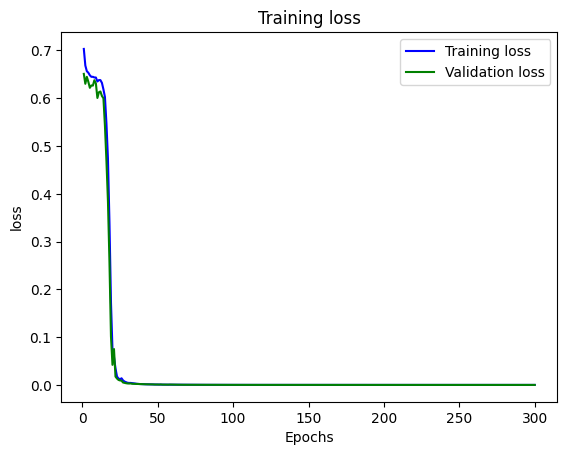

In [117]:

loss = history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [120]:

predictions= model.predict(X_val)
df_y=pd.DataFrame(np.concatenate((predictions, y_val.reshape(-1,1)),axis=1), columns=['predictions','true'])
df_y['predict_bin']=(df_y['predictions']>0.5).astype(int)

confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[107,   0],
       [  0,  93]])

54374/54374 ━━━━━━━━━━━━━━━━━━━━ 19s 341us/step
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step


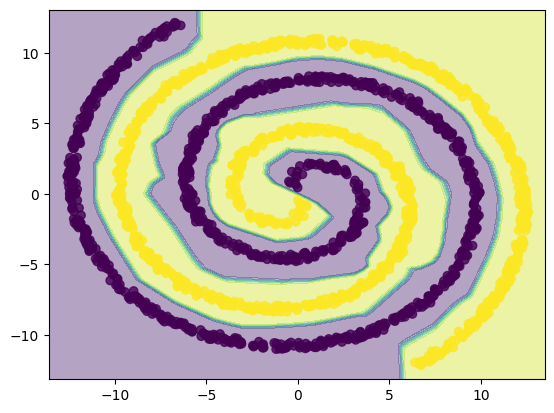

In [ ]:

# Código tomado de https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

